<a href="https://colab.research.google.com/github/SejinHan25/crack_segmentation/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Load

In [2]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/crack_segmentation/testdata.zip"

In [3]:
!unzip -qq "/content/drive/MyDrive/Colab Notebooks/crack_segmentation/traincrop.zip"

## 이미지 불러오기

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import glob
import seaborn as sns

from ipywidgets import interact
from PIL import Image
from glob import glob

In [11]:
# 원본 데이터
o_image_path = "/content/images/"
o_mask_path = "/content/masks/"

images_paths = glob(o_image_path+"*.jpg") + glob(o_image_path+"*.JPG") 
masks_paths = glob(o_mask_path + "*.png")

images_paths.sort()
masks_paths.sort()

# print(len(images_paths))
# print(len(masks_paths))

# print(images_paths)
# print(masks_paths)

df_origin = pd.DataFrame({'images': images_paths, 'masks': masks_paths})
df_origin.head(5)

,images,masks
0,/content/images/20160222_080933.jpg,/content/masks/20160222_080933_mask.png
1,/content/images/20160222_081839.jpg,/content/masks/20160222_081839_mask.png
2,/content/images/20160222_114759.jpg,/content/masks/20160222_114759_mask.png
3,/content/images/20160222_115305.jpg,/content/masks/20160222_115305_mask.png
4,/content/images/20160222_163940.jpg,/content/masks/20160222_163940_mask.png


In [12]:
# cropped 데이터
c_path = "/content/traincrop/"
masks_paths = glob(c_path + "*.png")

df_crop = pd.DataFrame({'masks': masks_paths})
df_crop.head(5)

,masks
0,/content/traincrop/20160330_170504_641_721.png
1,/content/traincrop/20160328_153553_641_721.png
2,/content/traincrop/20160316_143603_1_721.png
3,/content/traincrop/20160222_115858_641_1081.png
4,/content/traincrop/20160222_114806_1281_361.png


In [13]:
# 이미지 회전
for i in range(len(df_origin)):
    img_path = df_origin.iloc[i].images
    mask_path = df_origin.iloc[i].masks

    image = cv2.imread(img_path)
    mask = cv2.imread(mask_path)

    if image.shape[0] > image.shape[1]:
        os.remove(img_path)
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(img_path, image)


    if mask.shape[0] > mask.shape[1]:
        os.remove(mask_path)
        mask = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
        cv2.imwrite(mask_path, mask)

In [14]:
@interact(index=(0, len(df_origin)-1))
def show_images(index=0):
    image = cv2.imread(df_origin.iloc[index].images)
    mask = cv2.imread(df_origin.iloc[index].masks)

    plt.figure(figsize=(12,10))
    plt.subplot(121)
    plt.title("image")
    plt.imshow(image)
    plt.subplot(122)
    plt.title("mask")
    plt.imshow(mask)
    plt.tight_layout()

interactive(children=(IntSlider(value=0, description='index', max=199), Output()), _dom_classes=('widget-inter…

## Alpha Blending

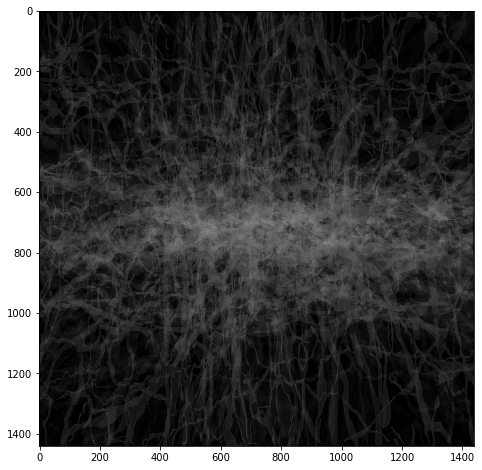

In [15]:
# 원본 이미지

dst = cv2.imread(df_origin.iloc[0].masks)
dst = cv2.resize(dst,(1440, 1440))

for i in range(0, len(df_origin)):
    if i == 0:
        pass
    else:
        img = cv2.imread(df_origin.iloc[i].masks)
        img = cv2.resize(img, (1440,1440))
        alpha = 1.0/(i+1)
        beta = 1.0 - alpha
        dst = cv2.addWeighted(img, alpha, dst, beta, 0)
        kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
        im = cv2.filter2D(dst, -1, kernel)
        
plt.figure(figsize=(8,8))
plt.imshow(im)

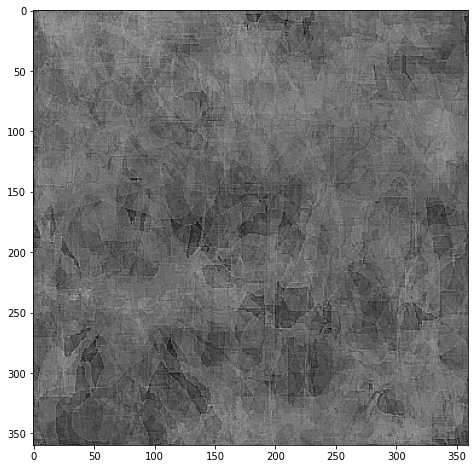

In [16]:
# cropped 이미지

dst = cv2.imread(df_crop.iloc[0].masks)
dst = cv2.resize(dst,(360, 360))

for i in range(0, len(df_crop)):
    if i == 0:
        pass
    else:
        img = cv2.imread(df_crop.iloc[i].masks)
        img = cv2.resize(img, (360,360))
        alpha = 1.0/(i+1)
        beta = 1.0 - alpha
        dst = cv2.addWeighted(img, alpha, dst, beta, 0)
        kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
        im = cv2.filter2D(dst, -1, kernel)
plt.figure(figsize=(8,8))
plt.imshow(im)

## Crack Rate

In [18]:
df_origin.head(5)

,images,masks
0,/content/images/20160222_080933.jpg,/content/masks/20160222_080933_mask.png
1,/content/images/20160222_081839.jpg,/content/masks/20160222_081839_mask.png
2,/content/images/20160222_114759.jpg,/content/masks/20160222_114759_mask.png
3,/content/images/20160222_115305.jpg,/content/masks/20160222_115305_mask.png
4,/content/images/20160222_163940.jpg,/content/masks/20160222_163940_mask.png


In [19]:
rate = []

for i in range(len(df_origin)):
    
    # 계산하기 편하도록 이미지를 GrayScale로 변환
    msk = cv2.imread(df_origin.iloc[i].masks)
    msk = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)

    white_pixel = np.sum(msk==255)
    black_pixel = np.sum(msk==0)

    res = round(white_pixel/(1440*2560) * 100, 2) # (균열 픽셀 수)/(전체 픽셀)X100 으로 균열이 이미지에서 차지하는 비율을 구한다.
    rate.append(res)

In [20]:
df_origin['rate'] = rate
df_origin.head(5)

,images,masks,rate
0,/content/images/20160222_080933.jpg,/content/masks/20160222_080933_mask.png,1.61
1,/content/images/20160222_081839.jpg,/content/masks/20160222_081839_mask.png,1.21
2,/content/images/20160222_114759.jpg,/content/masks/20160222_114759_mask.png,3.62
3,/content/images/20160222_115305.jpg,/content/masks/20160222_115305_mask.png,1.10
4,/content/images/20160222_163940.jpg,/content/masks/20160222_163940_mask.png,4.48


In [21]:
df_rate = df_origin.copy()

In [24]:
df_rate.images = [i for i in range(len(df_rate))]
df_rate.head(5)

,images,masks,rate
0,0,/content/masks/20160222_080933_mask.png,1.61
1,1,/content/masks/20160222_081839_mask.png,1.21
2,2,/content/masks/20160222_114759_mask.png,3.62
3,3,/content/masks/20160222_115305_mask.png,1.10
4,4,/content/masks/20160222_163940_mask.png,4.48


In [25]:
df_rate['rate'].describe()

count    200.000000
mean       2.991250
std        1.751442
min        0.150000
25%        1.807500
50%        2.465000
75%        3.750000
max       10.180000
Name: rate, dtype: float64

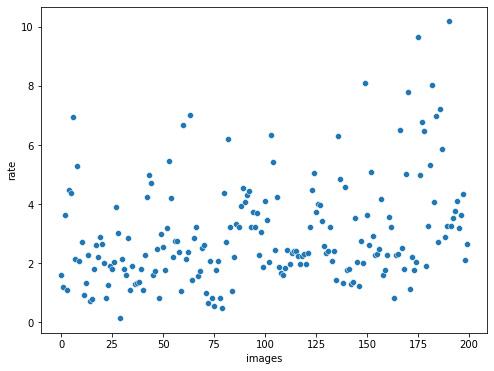

In [26]:
plt.figure(figsize=(8,6))
sns.scatterplot(x='images', y='rate', data=df_rate)

In [27]:
def rate_range(rate):
    if rate <= 1:
        return "0~1%"
    elif rate <= 2:
        return "1~2%"
    elif rate <= 3:
        return "2~3%"
    elif rate <= 4:
        return "3~4%"
    elif rate <= 5:
        return "4~5%"
    elif rate <= 6:
        return "5~6%"
    elif rate <= 7:
        return "6~7%"
    elif rate <= 8:
        return "7~8%"
    elif rate <= 9:
        return "8~9%"
    else:
        return "9~100%"

In [28]:
df_rate['rate_range'] = df_rate['rate'].apply(rate_range)
df_rate.head(5)

,images,masks,rate,rate_range
0,0,/content/masks/20160222_080933_mask.png,1.61,1~2%
1,1,/content/masks/20160222_081839_mask.png,1.21,1~2%
2,2,/content/masks/20160222_114759_mask.png,3.62,3~4%
3,3,/content/masks/20160222_115305_mask.png,1.10,1~2%
4,4,/content/masks/20160222_163940_mask.png,4.48,4~5%


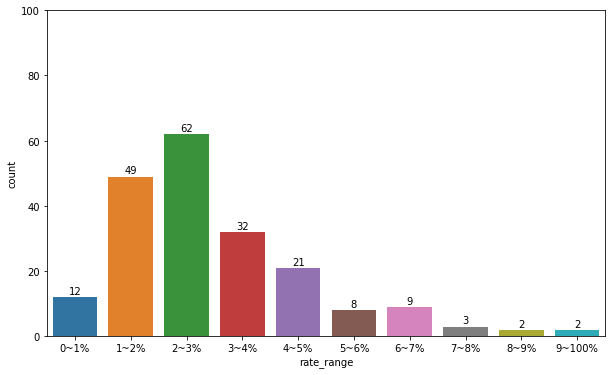

In [30]:
plt.figure(figsize=(10,6))
ax = sns.countplot(data=df_rate, x=df_rate['rate_range'].sort_values())
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height+1, height, ha = 'center', size = 10)
ax.set_ylim(0, 100)
plt.show()